# Home assigment 2

Please give your name below:

In [ ]:
name='Adéla Holmén'

## Exercise 2

Now you will put together the pieces you learnt in previous labs in order to write a continuous energy Monte Carlo particle transport simulation of a Uranium sphere! Your goal is to estimate the k-effective and to try to find the critical radius of a U-235 sphere. 

Your assumptions:

- The geometry is a sphere
- The sphere is made of pure U-235.
- You only care about the following reactions: capture, fission and elastic scattering 
- All scattering is isotropic in the CM frame.
- Neutrons emerge isotropically from fission.
- You received the pointwise cross sections and the energy dependent nubar data in the /data folder.
- You can neglect that in a fission event the number of generated neutrons is stochastic, and assume that always nubar neutrons are created.
- For the prompt neutron energies you can sample the Watt-distribution (see lecture notes, or Datalab 4)
- You do not need to track time (thus all neutrons can be considered to be prompt)
- Initially launch neutrons from the center of the sphere, then store fission sites, and later sample the new fission sites from this "bank".

Your tasks:

1. Plot the the cross section data and the nubar data.
2. Complete the support functions given below and the function `run()` in order to estimate the k-eigenvalue of a sphere with a continous energy 3D Monte Carlo particle transport simulation. The support functions are the ones which you saw in Datalab 5b (for example the direction transformations, elastic scattering etc.). Some of these functions you will need to update (eg. for the reaction type sampler, include fission). You can include other input parameters and set default values if you feel needed. For each neutron generation estimate the k-eigenvalue based on the initial number of neutrons and the new neutrons after the generation (as we did in Datalab 5a).
3. Modify the return list in order to return and plot other data
    - Plot the k-eigenvalue estimate vs the generation number
    - Plot how the estimated mean k-eigenvalue converges. (use such figures to argue about reasonable values for `NGEN`, `NPG`, `NSKIP`). 
4. Investigate how the k-eigenvalue depends on the radius of the sphere. Visualize this with matplotlib.
5. Find the critical radius. You can do this either with manual trial and error, or use an optimization method.


Hints: in this exercise you have to merge your knowledge from datalab 5a (ie. batchwise estimation of k-effective) and from datalab 5b (ie. tracking neutrons). If you are not sure about the validity of your results you can compare your findings with the values of critical radii from [Wikipedia](https://en.wikipedia.org/wiki/Critical_mass). Try to have similar order of magnitude results.

To be fair, in a real MC criticality calculation, the initial number of neutrons per cycle also fluctuates, and the k-eigenvalue is calculated with some power iteration. In that case some care needs to be taken to renormalize the number of events to be placed in the bank, in order to have more or less the same amount of starting neutrons in each batch, otherwise sub and supercritical systems would be problematic to be simulated (here p200-225 gives some details on that: https://mcnp.lanl.gov/pdf_files/la-ur-16-29043.pdf). You don't need to worry about these. We are satisfied with a simpler approach. Rather you will initiate the same amount of neutrons in each cycle, regardless how many were produced before, and we place every fission site into the bank, and sample the locations from that. We also do not require an initial guess for the k-eigenvalue (as you can see in the link for the power iteration based method, an initial guess is needed). 

In the first few cycles when we launch neutrons only from the center, we will probably underestimate leakage, so the estimates of $k$ will be biased. Therefore NSKIP just means that the first NSKIP number of cycle estimates of the k-effective should not be taken into account when calculating the mean of the k-effective, since the spatial distribution of the fission source is still biased by our original source location, and not spread yet throughout the geometry. Actually for this simple geometry NSKIP plays a less important role, so if you are not certain about what it is, feel free to ignore it. 

Try not to overcomplicate the exercise. The function `run()` with docstrings and comments can be written in less than 80 lines of code. Below we collected all the supporting functions from Datalab 4 and 5, which you will need to use. Some of them you need to update or finish first. We also loaded the nuclear data.

Also, ideally the computation should not be too slow. Test first with small NGEN and NPG values (eg. 100 for both). This should already provide decent accuracy. I tested that on an older laptop this many batches and particles can be run within a minute without any vectorization. If you experience that your computation is much longer, there might be a mistake.

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

#These load energy-dependent microscopic cross sections:
Es,xss=np.loadtxt('u235el.dat',skiprows=2).transpose() #xss: elastic scattering
Ec,xsc=np.loadtxt('u235cap.dat',skiprows=2).transpose() #xsc: radiative capture
Ef,xsf=np.loadtxt('u235fiss.dat',skiprows=2).transpose() #xsf: fission
Enu,nubar=np.loadtxt('u235nubar.dat',skiprows=2).transpose() #nubar: number of neutrons emitted per fission

density = 19.1 #g/cm3
A = 235
alpha=(A-1)**2/(A+1)**2

#TODO : get the macroscopic cross section
NA = 6.022e23  #Avogadro's number
rho = density  #g/cm^3
mass = A       #g/mol
N_atoms = (rho * NA) / mass  #atoms/cm^3


def getMacroXS(E):
    """
    Returns macroscopic cross sections [1/cm] and nubar at energy E.
    Interpolates pointwise data to return:
    SigS: scattering cross section
    SigC: capture cross section
    SigF: fission cross section
    nu: average fission neutrons
    """
    xs = np.interp(E, Es, xss)
    xc = np.interp(E, Ec, xsc)
    xf = np.interp(E, Ef, xsf)
    nu = np.interp(E, Enu, nubar)
    return xs * N_atoms * 1e-24, xc * N_atoms * 1e-24, xf * N_atoms * 1e-24, nu



##### SUPPORT functions
def distanceToCollision(SigT,N=1): #samples flight distance from exponential distribution
    x=np.random.uniform(0,1,N)
    return -np.log(x)/SigT


def reactionType(SigS, SigC, SigF): #randomly decides what happens at interaction
    SigT = SigS + SigC + SigF
    x = np.random.uniform(0, 1)
    if x < SigS / SigT:
        return 'scatter'
    elif x < (SigS + SigC) / SigT:
        return 'capture'
    else:
        return 'fission'


def elasticScatter(E): #changes energy and direction due to collision
    muC=np.random.uniform(-1,1)
    thetaC=np.arccos(muC)
    E=(((1+alpha)+(1-alpha)*muC)/2)*E
    thetaL=np.arctan2(np.sin(thetaC),((1/A)+muC))
    muL=np.cos(thetaL)
    return E, muL

def randomDir(): #isotropic direction sampling
    mu=np.random.uniform(-1,1)
    theta=np.arccos(mu)
    phi=np.random.uniform(0,2*np.pi)

    u=np.sin(theta)*np.cos(phi)
    v=np.sin(theta)*np.sin(phi)
    w=np.cos(theta)
    return np.array([u,v,w])

def transformDir(u,v,w,mu): #rotates neutron direction after scattering
    """
    transform coordinates according to openMC documentation.
    
    Parameters
    ----------
    u : float
        Old x-direction
    v : float
        Old y-direction
    w : float
        Old z-direction
    mu : float
        Lab cosine of scattering angle
    """
    phi=np.random.uniform(0,2*np.pi)
    un=mu*u+(np.sqrt(1-mu**2)*(u*w*np.cos(phi)-v*np.sin(phi)))/(np.sqrt(1-w**2))
    vn=mu*v+(np.sqrt(1-mu**2)*(v*w*np.cos(phi)+u*np.sin(phi)))/(np.sqrt(1-w**2))
    wn=mu*w-np.sqrt(1-mu**2)*np.sqrt(1-w**2)*np.cos(phi)
    return np.array([un,vn,wn])

def watt(x): 
    """
    Function to return the Watt distribution

    Parameters
    ----------
    x : float
        Energy in MeV
    """
    C1 = 0.453
    C2 = 0.965
    C3 = 2.29
    return C1*np.exp(-x/C2)*np.sinh(np.sqrt(C3*x))

def wattrnd(N): #sample neutron energies from Watt distribution (used for fission products)
    """
    Function to return energies sampled from the Watt-distribution.

    Parameters
    ----------
    N : int
        Number of samples needed
    """
    #TODO: you have to complete this function. You can use the rejection method
    # which we used in Datalab4. Just now the dots we plotted as "accepted" you 
    # can keep and return.
    # NOTE: take care of the energy units! Make sure, that the energy unit you use
    # here matches the energy unit used in your simulation!
    samples = []
    while len(samples) < N:
        x = np.random.uniform(0, 10)  #sample up to 10 MeV
        y = np.random.uniform(0, 0.5) #based on C1
        if y < watt(x):
            samples.append(x)
    samples = np.array(samples)
    return samples * 1e6 #return neutron energies in eV






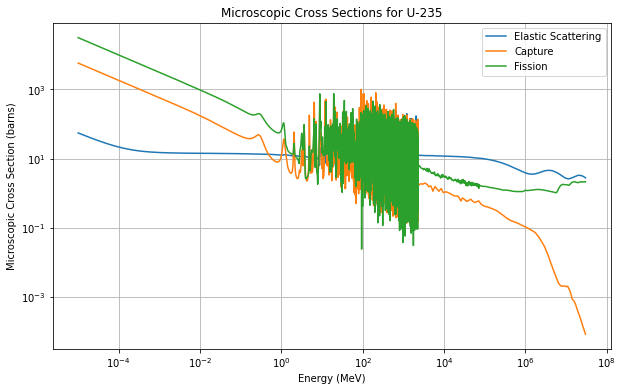

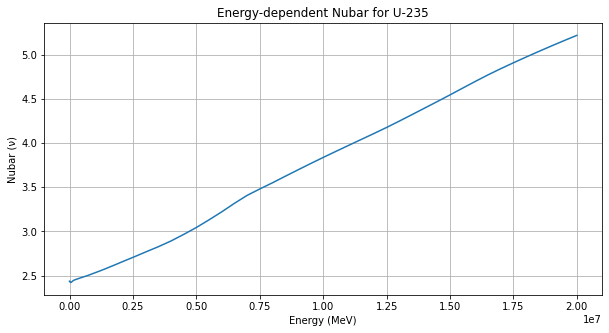

In [ ]:


#plot microscopic cross sections
plt.figure(figsize=(10, 6))
plt.plot(Es, xss, label='Elastic Scattering')
plt.plot(Ec, xsc, label='Capture')
plt.plot(Ef, xsf, label='Fission')
plt.xlabel('Energy (MeV)')
plt.ylabel('Microscopic Cross Section (barns)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Microscopic Cross Sections for U-235')
plt.grid(True)
plt.show() #comment: plot looks realistic

#plot nubar
plt.figure(figsize=(10, 5))
plt.plot(Enu, nubar)
plt.xlabel('Energy (MeV)')
plt.ylabel('Nubar (ν)')
plt.title('Energy-dependent Nubar for U-235')
plt.grid(True)
plt.show() #comment: number of neutrons emitted per fission increases with energy

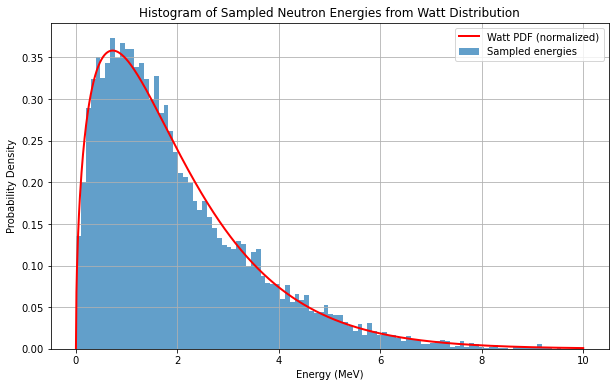

In [ ]:
#Check that the Watt distribution is correct

N_samples = 10000
samples_eV = wattrnd(N_samples)  
samples_MeV = samples_eV / 1e6

plt.figure(figsize=(10,6))
plt.hist(samples_MeV, bins=100, density=True, alpha=0.7, label='Sampled energies')

#plot the theoretical Watt distribution for comparison
x = np.linspace(0, 10, 1000) 
plt.plot(x, watt(x) / np.trapz(watt(x), x), 'r-', lw=2, label='Watt PDF (normalized)')

plt.xlabel('Energy (MeV)')
plt.ylabel('Probability Density')
plt.title('Histogram of Sampled Neutron Energies from Watt Distribution')
plt.legend()
plt.grid(True)
plt.show() #comment: the samples follow the theoretical Watt distribution nicely


In [6]:
def run(R, NGEN, NPG, NSKIP):
    """
    Function to perform a criticality calculation in a U-235 sphere.
    
    Parameters
    ----------
    R : float
        Radius of the sphere [cm]
    NGEN : int
        Number of neutron generations
    NPG : int
        Number of neutrons per generation
    NSKIP : int
        Number of inactive generations which will not be taken into account for estimating the k-eigenvalue

    Returns
    -------
    keff : float
        The estimated mean k-eigenvalue of the system
    kstd : float
        The standard deviation of the estimated k-eigenvalue
    keffs: list 
        All estimated keffs per generation
    """
    keffs = []
    bank = [[np.array([0., 0., 0.]), randomDir(), wattrnd(1)[0]] for _ in range(NPG)]  
    #start with NPG neutrons at the center, with energies sampled from Watt distribution
    
    for gen in range(NGEN): #for each generation
        new_sites = []
        for pos, dir, E in bank: #track every neutron
            while True:
                SigS, SigC, SigF, nu = getMacroXS(E) 
                SigT = SigS + SigC + SigF
                d = distanceToCollision(SigT)[0] #sample distance to collision
                new_pos = pos + d * dir
                if np.linalg.norm(new_pos) > R: #check for leakage (escapes if outside the sphere)
                    break  #leakage
                rxn = reactionType(SigS, SigC, SigF) #determine reaction: scatter, capture, or fission
                if rxn == 'capture':
                    break
                elif rxn == 'scatter':
                    E, mu = elasticScatter(E)
                    dir = transformDir(*dir, mu)
                    pos = new_pos
                elif rxn == 'fission': #for fission, generate ν new neutrons with Watt energies and store them
                    nfission = int(round(nu))
                    for _ in range(nfission):
                        new_sites.append([new_pos.copy(), randomDir(), wattrnd(1)[0]])
                    break
        keff = len(new_sites) / NPG #store k-effective as: k=number of fission neutrons/number of starting neutrons
        keffs.append(keff)
        #sample NPG fission neutrons from the bank to start the next generation:
        if len(new_sites) >= NPG: #there are enough fission sites (≥ NPG)
            bank = random.sample(new_sites, NPG) #randomly choose NPG unique elements from new_sites
        else: #there are too few fission sites (< NPG)
            bank = random.choices(new_sites, k=NPG) #we use random.choices, which samples with replacement (duplicates allowed)

    
    keff_active = keffs[NSKIP:] #only base mean and std dev of keff on active generations
    return np.mean(keff_active), np.std(keff_active), keffs



In [8]:
def plot_keff_convergence(keffs, NSKIP):
    #plot the k-eigenvalue estimate vs the generation number
    generations = np.arange(len(keffs))
    plt.figure(figsize=(10, 5)) 
    plt.plot(generations, keffs, label='k-effective per generation') #raw k-effective values per generation
    plt.axvline(NSKIP, color='r', linestyle='--', label='NSKIP')
    plt.xlabel('Generation')
    plt.ylabel('k-effective')
    plt.title('k-effective vs Generation')
    plt.grid(True)
    plt.legend()
    plt.show()
 
    #plot how the estimated mean k-eigenvalue converges
    means = [np.mean(keffs[NSKIP:i+1]) for i in range(NSKIP, len(keffs))]
    plt.figure(figsize=(10, 5))
    plt.plot(generations[NSKIP:], means, label='Mean k-effective') #rolling average of k-effective (from NSKIP onward)
    plt.xlabel('Generation')
    plt.ylabel('Mean k-effective')
    plt.title('Mean k-effective convergence')
    plt.grid(True)
    plt.legend()
    plt.show()


Running radius 2.00 cm...
Running radius 3.14 cm...
Running radius 4.29 cm...
Running radius 5.43 cm...
Running radius 6.57 cm...
Running radius 7.71 cm...
Running radius 8.86 cm...
Running radius 10.00 cm...


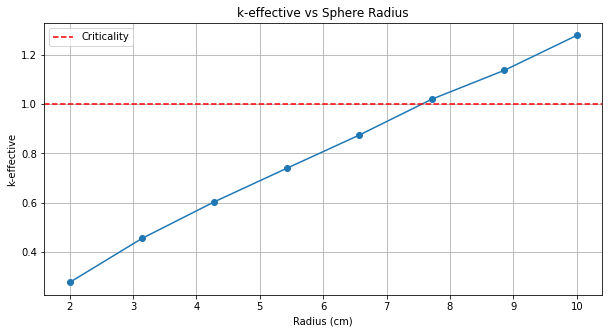

In [ ]:
def radius_scan(radii, NGEN=100, NPG=100, NSKIP=10): #runs run() for each radius in the radii array, collects k-effective values for each radius
    keff_means = []
    for R in radii:
        print(f"Running radius {R:.2f} cm...")
        k_mean, _, _= run(R, NGEN, NPG, NSKIP)
        keff_means.append(k_mean)
    return keff_means

radii = np.linspace(2, 10, 8)
keff_means = radius_scan(radii)

plt.figure(figsize=(10,5))
plt.plot(radii, keff_means, marker='o') #plots how k-effective changes with radius 
plt.axhline(1.0, color='r', linestyle='--', label='Criticality')  #shows the criticality condition line at k=1
plt.xlabel('Radius (cm)')
plt.ylabel('k-effective')
plt.title('k-effective vs Sphere Radius')
plt.grid(True)
plt.legend()
plt.show()

#comment: k increases with the radius of the sphere. According to the plot, critical k is at a radius of around 7.7 cm.
#According to wikipedia, the critical radius for U235 is 8.5 cm. Reasons for the discrepancy:
#In reality, U235 is not a perfectly homogeneous sphere, it has impurities.
#The simulation had no reflector: the critical radius would need to be larger in real configurations.
#Neutron leakage depends on energy. The model used a simplified assumption: that the neutron escapes if outside the sphere.
#All neutrons are considered to be prompt.
#etc.
#Still, the result is fairly close to the real value. (8.5 - 7.7 = 0.8 cm)




Estimated k-effective (mean over active generations): 1.03244 ± 0.14222


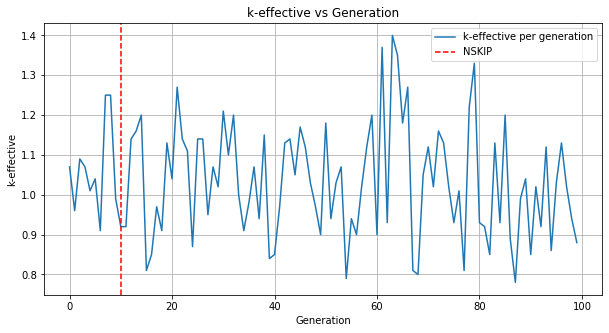

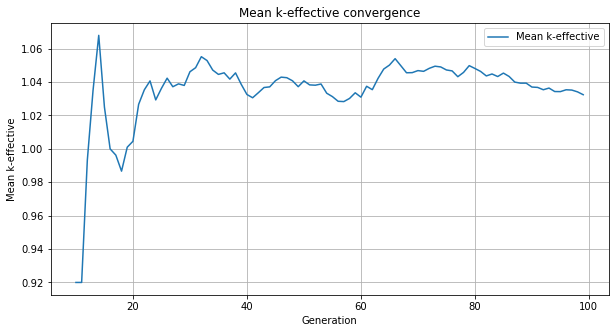

In [ ]:
R = 8.0  #try a radius that is close to critical 
NGEN = 100 #based on plot, this is reasonable, since the k fluctuates around 1.03/1.04 for a while. 
NPG = 100
NSKIP = 10 #based on plot, this is reasonable, since before 10 generations the k is low and rises sharply.

keff_mean, keff_std, keffs = run(R, NGEN, NPG, NSKIP)

print(f"\nEstimated k-effective (mean over active generations): {keff_mean:.5f} ± {keff_std:.5f}")
plot_keff_convergence(keffs, NSKIP)